In [1]:
!pip install xgboost
!pip install imblearn



In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler,label_binarize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression


from xgboost import XGBClassifier
from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score, f1_score,precision_score, recall_score, roc_auc_score, average_precision_score,roc_curve, precision_recall_curve, hamming_loss,auc
%matplotlib inline


from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
import gc

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data=pd.read_csv("/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_1.csv")
data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_2.csv")])
data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_3.csv")])
data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_4.csv")])
data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/final_1.csv")])
data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/final_2.csv")])
data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/final_3.csv")])
data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/final_4.csv")])
data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/final_5.csv")])

/tmp/ipython-input-3093493103.py:1: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv("/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_1.csv")
/tmp/ipython-input-3093493103.py:2: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_2.csv")])
/tmp/ipython-input-3093493103.py:3: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_3.csv")])
/tmp/ipython-input-3093493103.py:4: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_4.csv")])


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3679172 entries, 0 to 431
Data columns (total 46 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   pkSeqID                           int64  
 1   stime                             float64
 2   flgs                              object 
 3   flgs_number                       int64  
 4   proto                             object 
 5   proto_number                      int64  
 6   saddr                             object 
 7   sport                             object 
 8   daddr                             object 
 9   dport                             object 
 10  pkts                              int64  
 11  bytes                             int64  
 12  state                             object 
 13  state_number                      int64  
 14  ltime                             float64
 15  seq                               int64  
 16  dur                               float64
 17

In [6]:
data.columns

Index(['pkSeqID', 'stime', 'flgs', 'flgs_number', 'proto', 'proto_number',
       'saddr', 'sport', 'daddr', 'dport', 'pkts', 'bytes', 'state',
       'state_number', 'ltime', 'seq', 'dur', 'mean', 'stddev', 'sum', 'min',
       'max', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'srate', 'drate',
       'TnBPSrcIP', 'TnBPDstIP', 'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto',
       'TnP_Per_Dport', 'AR_P_Proto_P_SrcIP', 'AR_P_Proto_P_DstIP',
       'N_IN_Conn_P_DstIP', 'N_IN_Conn_P_SrcIP', 'AR_P_Proto_P_Sport',
       'AR_P_Proto_P_Dport', 'Pkts_P_State_P_Protocol_P_DestIP',
       'Pkts_P_State_P_Protocol_P_SrcIP', 'attack', 'category', 'subcategory'],
      dtype='object')

In [7]:
data=data.drop_duplicates()

In [8]:
#dropping irrelevant features
data=data.drop(columns=["pkSeqID","stime","flgs","proto","saddr","sport","daddr","dport","state","ltime","seq"])

In [9]:
#dropping correlated columns
data=data.drop(columns=["bytes","max","spkts","sbytes","dbytes","AR_P_Proto_P_Dport","state_number","dpkts"])

In [10]:
data.isnull().sum()

,0
flgs_number,0
proto_number,0
pkts,0
dur,0
mean,0
stddev,0
sum,0
min,0
rate,0
srate,0


In [11]:
data.head()

,flgs_number,proto_number,pkts,dur,mean,stddev,sum,min,rate,srate,...,AR_P_Proto_P_SrcIP,AR_P_Proto_P_DstIP,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,AR_P_Proto_P_Sport,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,attack,category,subcategory
0,1,1,8,7.056393,0.068909,0.068909,0.137818,0.000000,0.992008,0.566862,...,1.142970,1.12704,96,75,1.133720,770,602,1,DoS,HTTP
1,1,2,2,0.000131,0.000131,0.000000,0.000131,0.000131,7633.588379,0.000000,...,0.003857,15267.20000,1,2,0.005142,2,6,1,DoS,HTTP
2,1,1,8,7.047852,0.064494,0.064494,0.128988,0.000000,0.993210,0.567549,...,1.142970,1.12704,96,75,1.135100,770,602,1,DoS,HTTP
3,1,1,8,7.047592,0.064189,0.064189,0.128378,0.000000,0.993247,0.567570,...,1.142970,1.12704,96,75,1.135140,770,602,1,DoS,HTTP
4,1,1,8,7.046841,0.063887,0.063887,0.127774,0.000000,0.993353,0.567630,...,1.142970,1.12704,96,75,1.135260,770,602,1,DoS,HTTP


In [12]:

categories_to_reduce = ['DDoS', 'DoS', 'Reconnaissance']
target_count = 30000

def reduce_samples(df, categories, target_count):
    reduced_df = pd.DataFrame()

    for category in categories:
        category_df = df[df['category'] == category]
        print(f"Original count for {category}: {len(category_df)}")

        if len(category_df) > target_count:
            category_df = category_df.sample(n=target_count, random_state=42)
            print(f"Reduced to {len(category_df)} for {category}")
        else:
            print(f"No reduction needed for {category}")

        reduced_df = pd.concat([reduced_df, category_df], ignore_index=True)

    other_df = df[~df['category'].isin(categories)]
    reduced_df = pd.concat([reduced_df, other_df], ignore_index=True)

    return reduced_df

data = reduce_samples(data, categories_to_reduce, target_count)



Original count for DDoS: 1926624
Reduced to 30000 for DDoS
Original count for DoS: 1650260
Reduced to 30000 for DoS
Original count for Reconnaissance: 91082
Reduced to 30000 for Reconnaissance


In [13]:
data['category'].value_counts()

,count
category,
DDoS,30000
DoS,30000
Reconnaissance,30000
Normal,9549
Theft,1657


In [14]:
data["attack"].value_counts()

,count
attack,
1,91657
0,9549


In [15]:
data["subcategory"].value_counts()

,count
subcategory,
UDP,33632
TCP,26327
Service_Scan,24162
Normal,9549
OS_Fingerprint,5838
Keylogging,1537
Data_Exfiltration,120
HTTP,41


In [16]:
le = LabelEncoder()
data['category'] = le.fit_transform(data['category'])
data['subcategory'] = le.fit_transform(data['subcategory'])
data.head()

,flgs_number,proto_number,pkts,dur,mean,stddev,sum,min,rate,srate,...,AR_P_Proto_P_SrcIP,AR_P_Proto_P_DstIP,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,AR_P_Proto_P_Sport,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,attack,category,subcategory
0,1,3,15,13.955115,3.982232,1.413917,11.946695,1.982758,1.003216,1.003216,...,1.074890,1.037410,100,93,1.074870,1451,1395,1,0,7
1,1,3,14,13.962423,3.987533,0.821593,11.962599,2.983338,0.931070,0.931070,...,1.055830,0.958112,100,62,1.002690,1332,914,1,0,7
2,2,1,5,12.984385,2.199934,1.563204,6.599802,0.000000,0.308062,0.308062,...,0.426398,0.426398,100,100,0.385078,360,360,1,0,6
3,1,3,8,14.194972,3.381320,0.950962,10.143960,2.036473,0.493132,0.493132,...,0.563580,0.563580,100,100,0.563580,800,800,1,0,7
4,1,1,3,0.210202,0.210202,0.000000,0.210202,0.210202,9.514658,4.757329,...,21.318300,21.318300,100,100,14.272000,114,114,1,0,6


In [17]:
Y = data[['attack','category','subcategory']]
X= data.drop(['attack','category','subcategory'],axis=1)

In [18]:
X.head()

,flgs_number,proto_number,pkts,dur,mean,stddev,sum,min,rate,srate,...,TnP_PDstIP,TnP_PerProto,TnP_Per_Dport,AR_P_Proto_P_SrcIP,AR_P_Proto_P_DstIP,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,AR_P_Proto_P_Sport,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP
0,1,3,15,13.955115,3.982232,1.413917,11.946695,1.982758,1.003216,1.003216,...,1451,1451,1451,1.074890,1.037410,100,93,1.074870,1451,1395
1,1,3,14,13.962423,3.987533,0.821593,11.962599,2.983338,0.931070,0.931070,...,1332,1332,1332,1.055830,0.958112,100,62,1.002690,1332,914
2,2,1,5,12.984385,2.199934,1.563204,6.599802,0.000000,0.308062,0.308062,...,556,556,556,0.426398,0.426398,100,100,0.385078,360,360
3,1,3,8,14.194972,3.381320,0.950962,10.143960,2.036473,0.493132,0.493132,...,800,800,800,0.563580,0.563580,100,100,0.563580,800,800
4,1,1,3,0.210202,0.210202,0.000000,0.210202,0.210202,9.514658,4.757329,...,176,176,176,21.318300,21.318300,100,100,14.272000,114,114


In [19]:
#mutual information
mi_attack = mutual_info_classif(X, Y["attack"])
mi_subcat = mutual_info_classif(X, Y["subcategory"])
mi_cat    = mutual_info_classif(X, Y["category"])
mi_avg = (mi_attack + mi_subcat + mi_cat) / 3

df_mi = pd.DataFrame({
    'feature': X.columns.tolist(),
    'MI_attack': mi_attack,
    'MI_subcategory': mi_subcat,
    'MI_category': mi_cat,
    'MI_average': mi_avg
})

df_mi_sorted = df_mi.sort_values(by='MI_average', ascending=False)
top_features = df_mi_sorted.head(20)['feature'].tolist()
X = X[top_features]


In [20]:
X.head()

,AR_P_Proto_P_DstIP,AR_P_Proto_P_SrcIP,AR_P_Proto_P_Sport,TnBPDstIP,TnBPSrcIP,dur,rate,TnP_Per_Dport,TnP_PerProto,TnP_PDstIP,srate,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,TnP_PSrcIP,sum,mean,pkts,min,stddev,N_IN_Conn_P_DstIP
0,1.037410,1.074890,1.074870,87060,83700,13.955115,1.003216,1451,1451,1451,1.003216,1451,1395,1395,11.946695,3.982232,15,1.982758,1.413917,100
1,0.958112,1.055830,1.002690,79920,54840,13.962423,0.931070,1332,1332,1332,0.931070,1332,914,914,11.962599,3.987533,14,2.983338,0.821593,100
2,0.426398,0.426398,0.385078,80360,80360,12.984385,0.308062,556,556,556,0.308062,360,360,556,6.599802,2.199934,5,0.000000,1.563204,100
3,0.563580,0.563580,0.563580,48000,48000,14.194972,0.493132,800,800,800,0.493132,800,800,800,10.143960,3.381320,8,2.036473,0.950962,100
4,21.318300,21.318300,14.272000,19960,19960,0.210202,9.514658,176,176,176,4.757329,114,114,176,0.210202,0.210202,3,0.210202,0.000000,100


In [21]:
#tree based feature selection
model = XGBClassifier(tree_method='hist', n_jobs=-1)
model.fit(X, Y["attack"])

model1 = XGBClassifier(tree_method='hist', n_jobs=-1)
model1.fit(X, Y["subcategory"])

model2 = XGBClassifier(tree_method='hist', n_jobs=-1)
model2.fit(X, Y["category"])


importances = model.feature_importances_
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

top_features = importance_df['feature'].head(15)

importances = model1.feature_importances_
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

top_features1 = importance_df['feature'].head(15)

importances = model2.feature_importances_
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

top_features2 = importance_df['feature'].head(15)


combined_features = set(top_features) | set(top_features1) | set(top_features2)
X = X[list(combined_features)]

In [22]:
X.head()

,rate,srate,N_IN_Conn_P_DstIP,TnBPDstIP,TnP_PerProto,sum,Pkts_P_State_P_Protocol_P_DestIP,min,TnP_Per_Dport,TnP_PDstIP,AR_P_Proto_P_Sport,TnP_PSrcIP,stddev,TnBPSrcIP,dur,AR_P_Proto_P_SrcIP,AR_P_Proto_P_DstIP,Pkts_P_State_P_Protocol_P_SrcIP,pkts
0,1.003216,1.003216,100,87060,1451,11.946695,1451,1.982758,1451,1451,1.074870,1395,1.413917,83700,13.955115,1.074890,1.037410,1395,15
1,0.931070,0.931070,100,79920,1332,11.962599,1332,2.983338,1332,1332,1.002690,914,0.821593,54840,13.962423,1.055830,0.958112,914,14
2,0.308062,0.308062,100,80360,556,6.599802,360,0.000000,556,556,0.385078,556,1.563204,80360,12.984385,0.426398,0.426398,360,5
3,0.493132,0.493132,100,48000,800,10.143960,800,2.036473,800,800,0.563580,800,0.950962,48000,14.194972,0.563580,0.563580,800,8
4,9.514658,4.757329,100,19960,176,0.210202,114,0.210202,176,176,14.272000,176,0.000000,19960,0.210202,21.318300,21.318300,114,3


In [23]:
sc = StandardScaler()
X = sc.fit_transform(X)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)


In [25]:
# Smote Oversampling
y_all = y_train[['attack', 'category', 'subcategory']].reset_index(drop=True)

sm = SMOTE(k_neighbors=3, random_state=42)
X_resampled, y_attack_resampled = sm.fit_resample(X_train, y_all['attack'])

n_original = len(X_train)
n_total = len(X_resampled)
n_synthetic = n_total - n_original

normal_cat = le.transform(["Normal"])[0]
normal_subcat = le.transform(["Normal"])[0]

y_category_resampled = pd.concat([
    y_all['category'],
    pd.Series([normal_cat] * n_synthetic)
], ignore_index=True)

y_subcategory_resampled = pd.concat([
    y_all['subcategory'],
    pd.Series([normal_subcat] * n_synthetic)
], ignore_index=True)

y_train_resampled = pd.DataFrame({
    "attack": y_attack_resampled,
    "category": y_category_resampled,
    "subcategory": y_subcategory_resampled
})

X_train = X_resampled
y_train = y_train_resampled



In [26]:
class RandomForest:
    def __init__(self,max_depth):
        self.rfc_attack = RandomForestClassifier(max_depth=max_depth)
        self.rfc_category = RandomForestClassifier(max_depth=max_depth)
        self.rfc_subcategory = RandomForestClassifier(max_depth=max_depth)

    def fit(self,X_train,y_train):
        self.rfc_attack.fit(X_train,y_train['attack'])

        features_category = np.concatenate((X_train,np.array(y_train['attack']).reshape(-1,1)),axis=1)
        self.rfc_category.fit(features_category,y_train['category'])

        features_subcategory = np.concatenate((features_category,np.array(y_train['category']).reshape(-1,1)),axis=1)
        self.rfc_subcategory.fit(features_subcategory,y_train['subcategory'])

    def predict(self,X_test):
        predict_attack = self.rfc_attack.predict(X_test)
        y_proba=self.rfc_attack.predict_proba(X_test)[:,1]
        test_category = np.concatenate((X_test,predict_attack.reshape(-1,1)),axis=1)
        predict_category = self.rfc_category.predict(test_category)

        test_subcategory = np.concatenate((test_category,predict_category.reshape(-1,1)),axis=1)
        predict_subcategory = self.rfc_subcategory.predict(test_subcategory)



        return pd.DataFrame({'attack':predict_attack,'category':predict_category,'subcategory':predict_subcategory,"y_proba":y_proba})

In [27]:
def display_metrics(y_true, y_pred, title, y_proba=None):
    print(f"\n--- {title} ---")

    print("\n📋 Classification Report:")
    report = classification_report(y_true, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    print(df_report.iloc[:-3])
    print("\n📊 Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    acc = accuracy_score(y_true, y_pred)
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    ham_loss = hamming_loss(y_true, y_pred)

    print(f"\n✅ Accuracy: {acc:.4f}")
    print(f"✅ Weighted F1 Score: {f1_weighted:.4f}")
    print(f"✅ Macro F1 Score: {f1_macro:.4f}")
    print(f"✅ Macro Precision: {precision_macro:.4f}")
    print(f"✅ Macro Recall: {recall_macro:.4f}")
    print(f"❌ Hamming Loss: {ham_loss:.6f}")

    if y_proba is not None:
        n_classes = pd.Series(y_true).nunique()
        if n_classes == 2:
            roc_auc = roc_auc_score(y_true, y_proba)
            pr_auc = average_precision_score(y_true, y_proba)
            print(f"📈 ROC AUC Score: {roc_auc:.4f}")
            print(f"📈 PR AUC Score: {pr_auc:.4f}")

            fpr, tpr, _ = roc_curve(y_true, y_proba)
            plt.figure()
            plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curve")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

            precision, recall, _ = precision_recall_curve(y_true, y_proba)
            plt.figure()
            plt.plot(recall, precision, label=f"AP = {pr_auc:.2f}")
            plt.xlabel("Recall")
            plt.ylabel("Precision")
            plt.title("Precision-Recall Curve")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

**Random Forest**

In [28]:
rf = RandomForest(max_depth=3)
rf.fit(X_train,y_train)

predictions_rfc = rf.predict(X_test)




--- Attack Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.973210  0.989005  0.981044   1910.0
1   0.998853  0.997163  0.998007  18332.0

📊 Confusion Matrix:


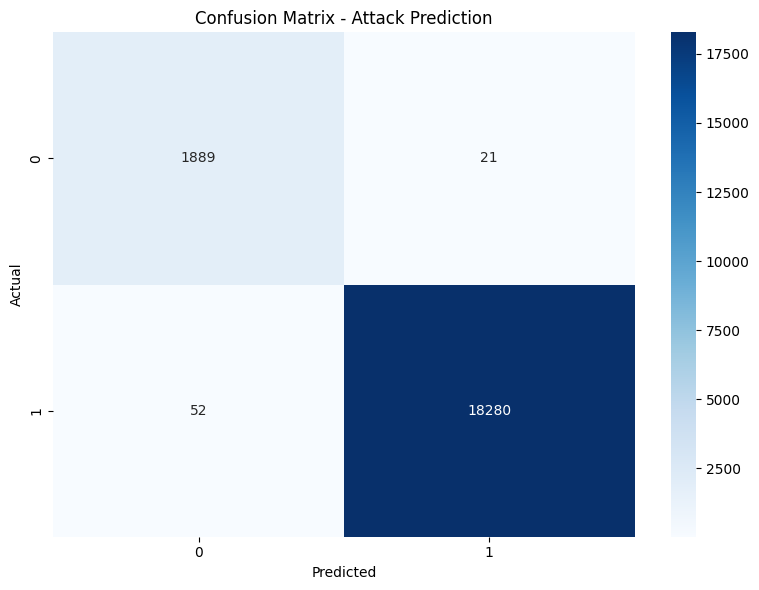


✅ Accuracy: 0.9964
✅ Weighted F1 Score: 0.9964
✅ Macro F1 Score: 0.9895
✅ Macro Precision: 0.9860
✅ Macro Recall: 0.9931
❌ Hamming Loss: 0.003606
📈 ROC AUC Score: 0.9998
📈 PR AUC Score: 1.0000


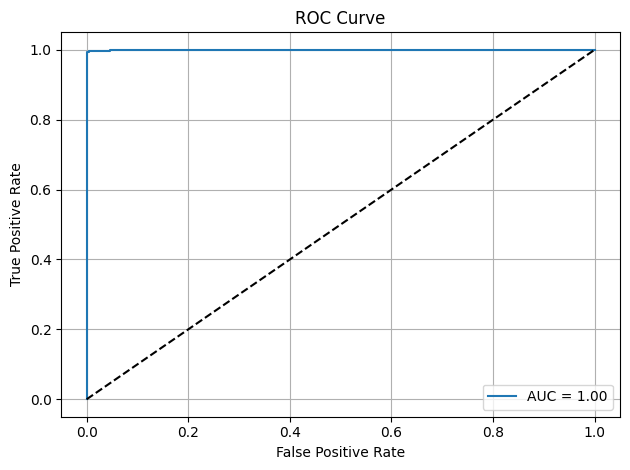

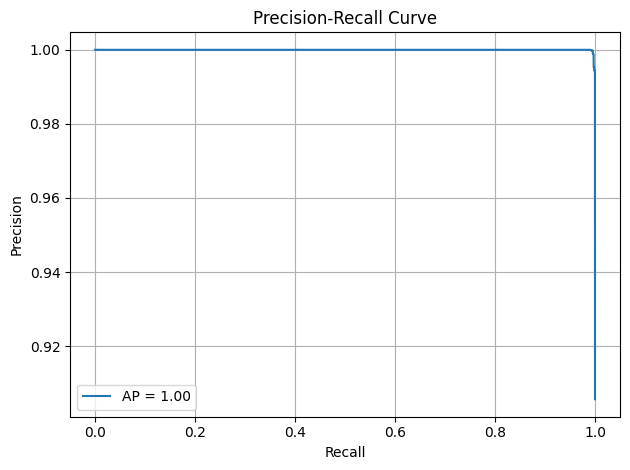

In [29]:
display_metrics(y_test['attack'], predictions_rfc['attack'], "Attack Prediction",predictions_rfc["y_proba"])




--- Category Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.996197  0.829500  0.905238   6000.0
1   0.895338  0.953833  0.923660   6000.0
2   0.000000  0.000000  0.000000   1910.0
3   0.694100  0.997834  0.818704   6001.0
4   1.000000  0.685801  0.813620    331.0

📊 Confusion Matrix:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


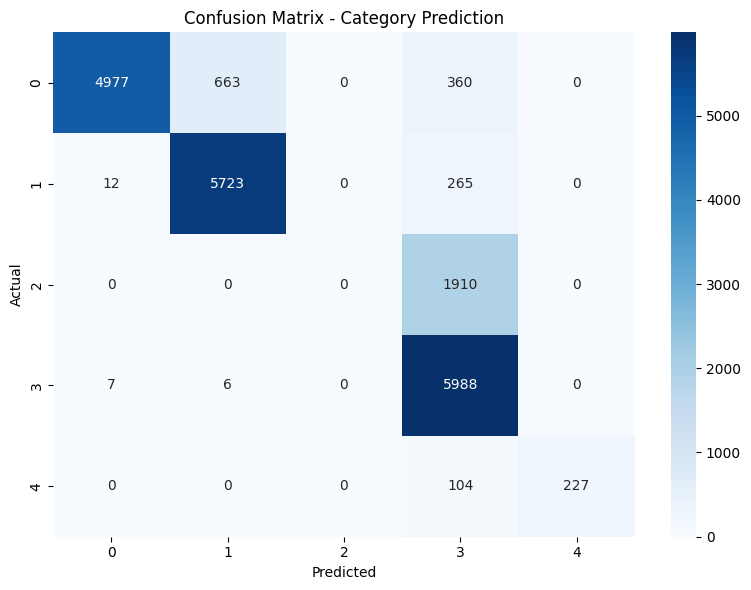


✅ Accuracy: 0.8356
✅ Weighted F1 Score: 0.7981
✅ Macro F1 Score: 0.6922
✅ Macro Precision: 0.7171
✅ Macro Recall: 0.6934
❌ Hamming Loss: 0.164361


In [30]:
display_metrics(y_test['category'], predictions_rfc['category'], "Category Prediction")



--- Subcategory Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.000000  0.000000  0.000000     24.0
1   0.000000  0.000000  0.000000      9.0
2   0.975410  0.775244  0.863884    307.0
3   0.959370  0.989005  0.973962   1910.0
4   0.000000  0.000000  0.000000   1168.0
5   0.727245  0.998552  0.841573   4833.0
6   0.949324  0.800570  0.868624   5265.0
7   0.937725  0.969373  0.953286   6726.0

📊 Confusion Matrix:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


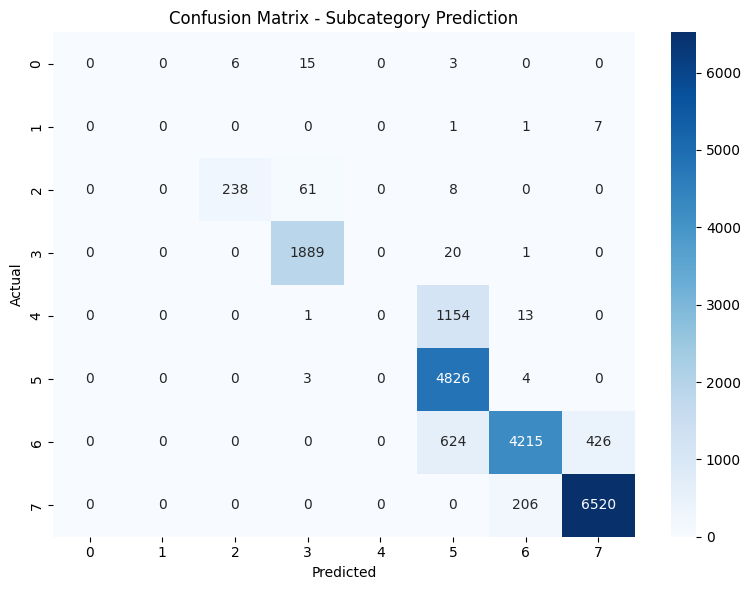


✅ Accuracy: 0.8738
✅ Weighted F1 Score: 0.8486
✅ Macro F1 Score: 0.5627
✅ Macro Precision: 0.5686
✅ Macro Recall: 0.5666
❌ Hamming Loss: 0.126173


In [31]:
display_metrics(y_test['subcategory'], predictions_rfc['subcategory'], "Subcategory Prediction")

XGB graddient boosting


In [33]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train["attack"])

# Predict
y_pred_xgb = xgb_model.predict(X_test)

y_proba = xgb_model.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:38:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Attack Prediction ---

📋 Classification Report:
   precision  recall  f1-score  support
0        1.0     1.0       1.0   1910.0
1        1.0     1.0       1.0  18332.0

📊 Confusion Matrix:


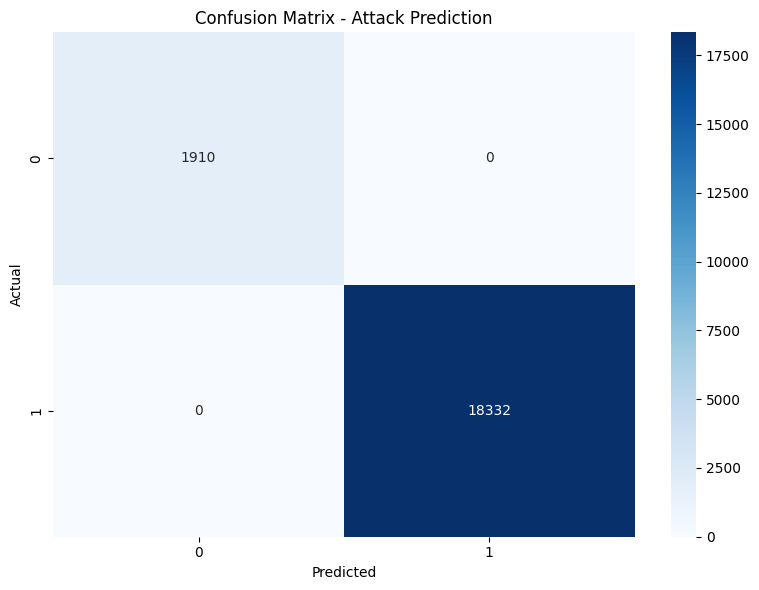


✅ Accuracy: 1.0000
✅ Weighted F1 Score: 1.0000
✅ Macro F1 Score: 1.0000
✅ Macro Precision: 1.0000
✅ Macro Recall: 1.0000
❌ Hamming Loss: 0.000000
📈 ROC AUC Score: 1.0000
📈 PR AUC Score: 1.0000


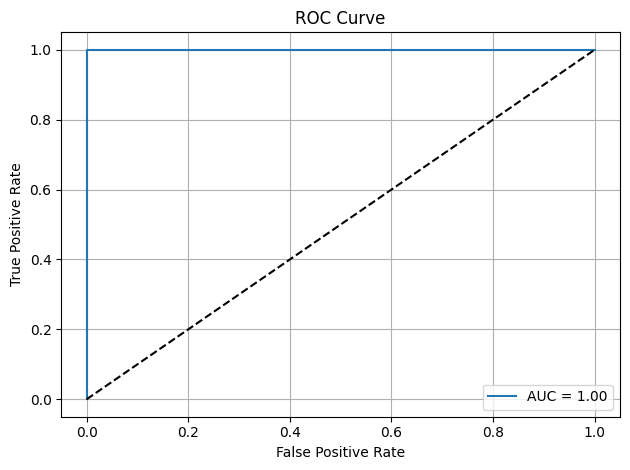

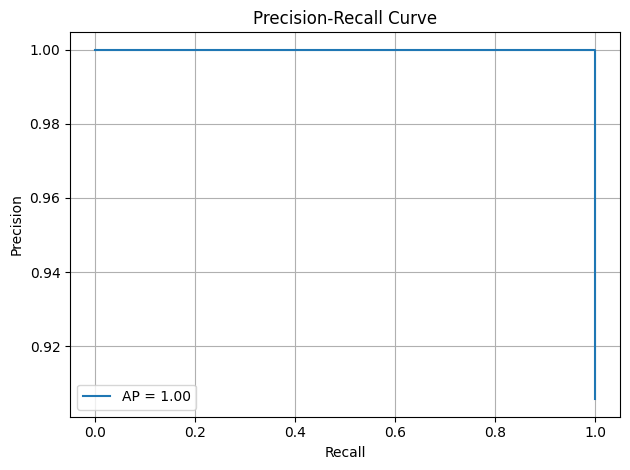

In [34]:
display_metrics(y_test['attack'], y_pred_xgb, "Attack Prediction",y_proba)


In [35]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train["category"])

# Predict
y_pred_xgb = xgb_model.predict(X_test)



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:38:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Category Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.999833  0.999333  0.999583   6000.0
1   0.999334  1.000000  0.999667   6000.0
2   1.000000  0.042408  0.081366   1910.0
3   0.766284  0.999833  0.867616   6001.0
4   1.000000  0.996979  0.998487    331.0

📊 Confusion Matrix:


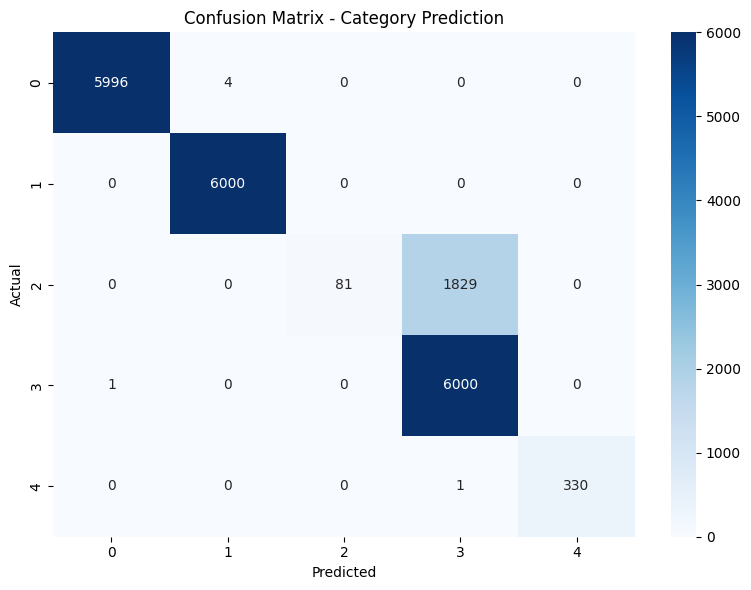


✅ Accuracy: 0.9093
✅ Weighted F1 Score: 0.8738
✅ Macro F1 Score: 0.7893
✅ Macro Precision: 0.9531
✅ Macro Recall: 0.8077
❌ Hamming Loss: 0.090653


In [36]:
display_metrics(y_test['category'], y_pred_xgb, "Category Prediction")

In [37]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train["subcategory"])

# Predict
y_pred_xgb = xgb_model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:39:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Subcategory Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.730769  0.791667  0.760000     24.0
1   1.000000  0.777778  0.875000      9.0
2   0.986799  0.973941  0.980328    307.0
3   0.998954  1.000000  0.999477   1910.0
4   0.944299  0.928938  0.936556   1168.0
5   0.982894  0.986758  0.984822   4833.0
6   0.999620  1.000000  0.999810   5265.0
7   1.000000  1.000000  1.000000   6726.0

📊 Confusion Matrix:


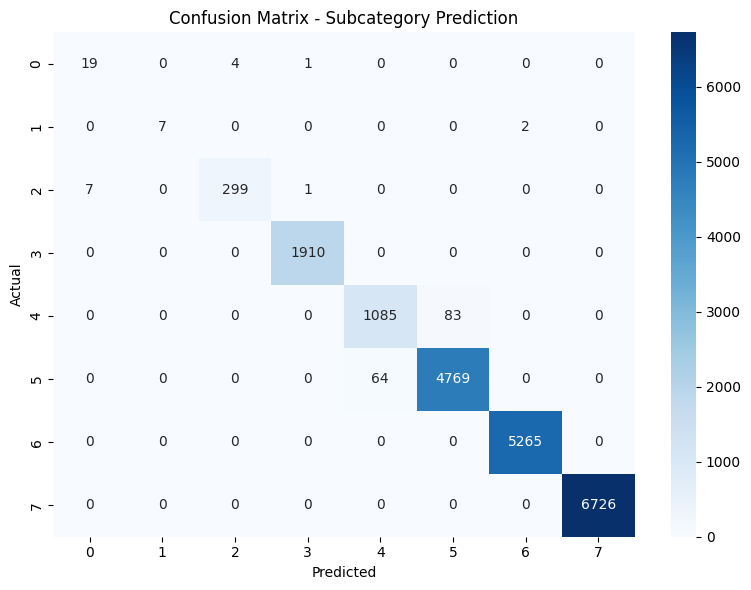


✅ Accuracy: 0.9920
✅ Weighted F1 Score: 0.9920
✅ Macro F1 Score: 0.9420
✅ Macro Precision: 0.9554
✅ Macro Recall: 0.9324
❌ Hamming Loss: 0.008003


In [38]:
display_metrics(y_test['subcategory'], y_pred_xgb, "Subcategory Prediction")

Logistic Regression


In [40]:
logreg_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
logreg_model.fit(X_train, y_train["attack"])

# Predict
y_pred_logreg = logreg_model.predict(X_test)

y_proba = logreg_model.predict_proba(X_test)[:, 1]


--- Attack Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.997862  0.977487  0.987569   1910.0
1   0.997659  0.999782  0.998719  18332.0

📊 Confusion Matrix:


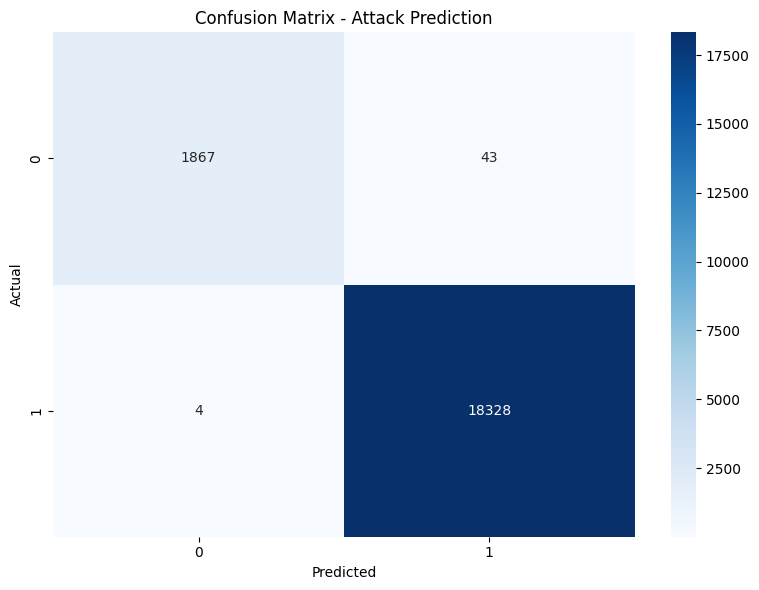


✅ Accuracy: 0.9977
✅ Weighted F1 Score: 0.9977
✅ Macro F1 Score: 0.9931
✅ Macro Precision: 0.9978
✅ Macro Recall: 0.9886
❌ Hamming Loss: 0.002322
📈 ROC AUC Score: 0.9979
📈 PR AUC Score: 0.9992


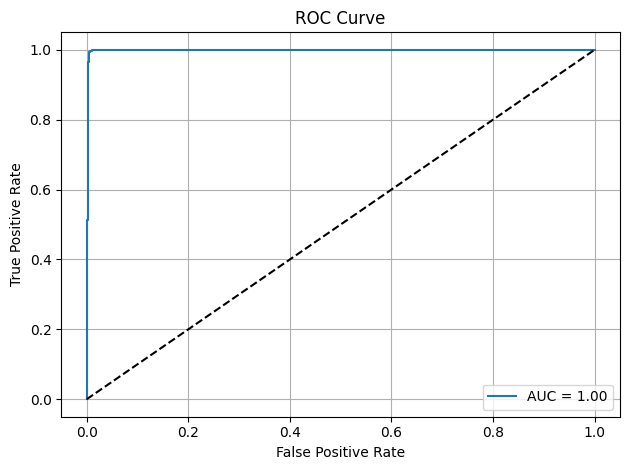

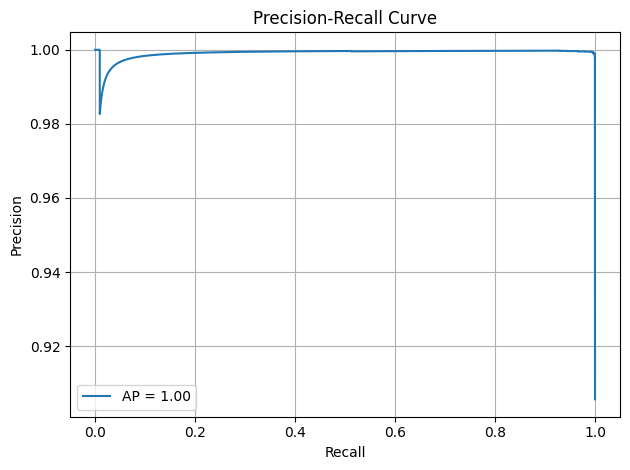

In [41]:
display_metrics(y_test['attack'], y_pred_logreg, "Attack Prediction",y_proba)


In [42]:
logreg_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
logreg_model.fit(X_train, y_train["category"])

# Predict
y_pred_logreg = logreg_model.predict(X_test)



--- Category Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.788393  0.883000  0.833019   6000.0
1   0.867712  0.783833  0.823643   6000.0
2   0.000000  0.000000  0.000000   1910.0
3   0.693899  0.900183  0.783694   6001.0
4   1.000000  0.957704  0.978395    331.0

📊 Confusion Matrix:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


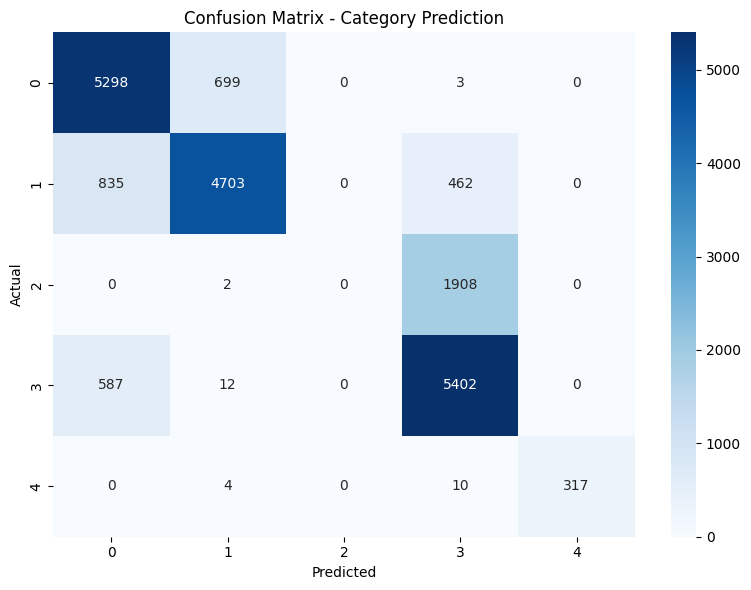


✅ Accuracy: 0.7766
✅ Weighted F1 Score: 0.7394
✅ Macro F1 Score: 0.6838
✅ Macro Precision: 0.6700
✅ Macro Recall: 0.7049
❌ Hamming Loss: 0.223397


In [43]:
display_metrics(y_test['category'], y_pred_logreg, "Category Prediction")

In [44]:
logreg_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
logreg_model.fit(X_train, y_train["subcategory"])

# Predict
y_pred_logreg = logreg_model.predict(X_test)


--- Subcategory Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.000000  0.000000  0.000000     24.0
1   0.000000  0.000000  0.000000      9.0
2   0.936909  0.967427  0.951923    307.0
3   0.991649  0.994764  0.993204   1910.0
4   0.500000  0.000856  0.001709   1168.0
5   0.769944  0.876681  0.819853   4833.0
6   0.849430  0.863628  0.856470   5265.0
7   0.918333  0.976360  0.946458   6726.0

📊 Confusion Matrix:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


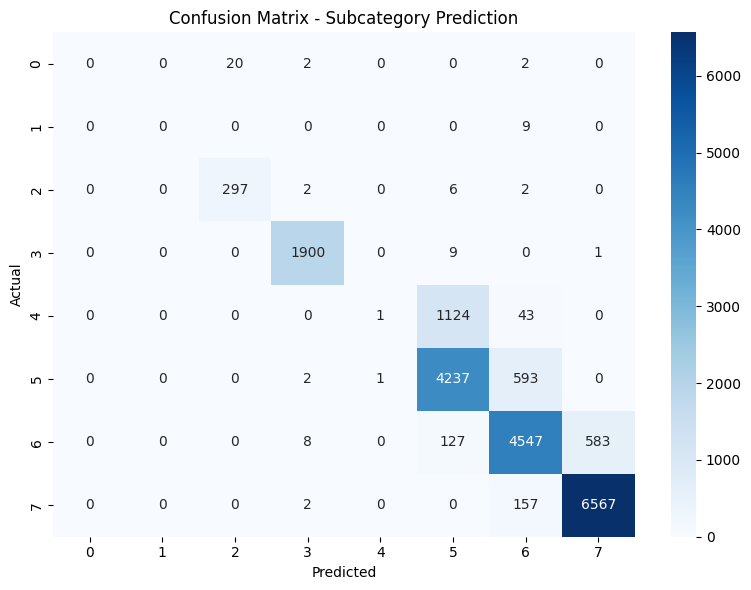


✅ Accuracy: 0.8670
✅ Weighted F1 Score: 0.8413
✅ Macro F1 Score: 0.5712
✅ Macro Precision: 0.6208
✅ Macro Recall: 0.5850
❌ Hamming Loss: 0.133040


In [45]:
display_metrics(y_test['subcategory'], y_pred_logreg, "Subcategory Prediction")

Stacked Model

In [47]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
rf = RandomForestClassifier(class_weight="balanced")
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)


meta_model = LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=200,class_weight="balanced")


stacked = StackingClassifier(
    estimators=[('xgb', xgb), ('rf', rf)],
    final_estimator=meta_model,
    cv=cv,
    passthrough=False,
    n_jobs=1
)


stacked.fit(X_train, y_train["attack"])



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:42:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:42:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:42:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to av

StackingClassifier(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='mlogloss',
                                              feature_types=None,
                                              feature_weights=None,...
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('rf',
                                RandomForestClassifier(class_weight='balanced'))],
                   final_estimator=LogisticRegression(class_weight='balanced',
                                                      max_iter=200,
                                                      multi_class='multinomial'),
                   n_jobs=1)


--- Attack ---

📋 Classification Report:
   precision  recall  f1-score  support
0        1.0     1.0       1.0   1910.0
1        1.0     1.0       1.0  18332.0

📊 Confusion Matrix:


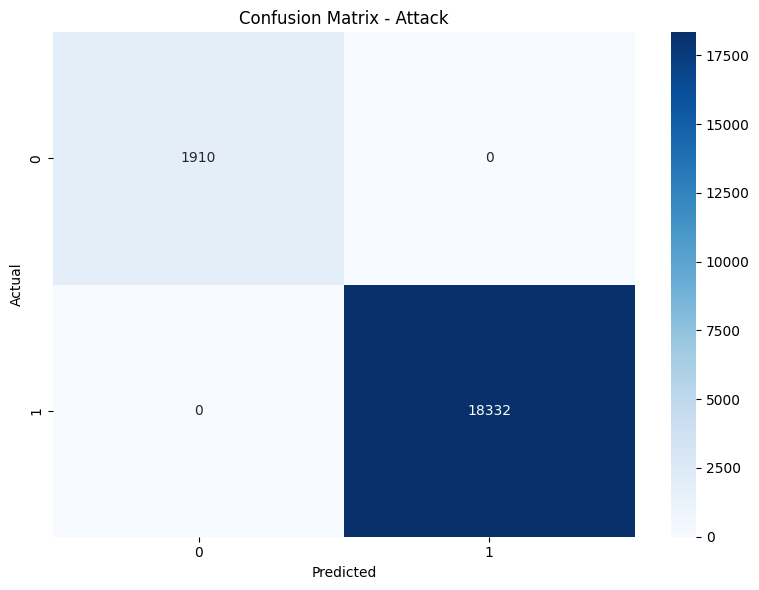


✅ Accuracy: 1.0000
✅ Weighted F1 Score: 1.0000
✅ Macro F1 Score: 1.0000
✅ Macro Precision: 1.0000
✅ Macro Recall: 1.0000
❌ Hamming Loss: 0.000000
📈 ROC AUC Score: 1.0000
📈 PR AUC Score: 1.0000


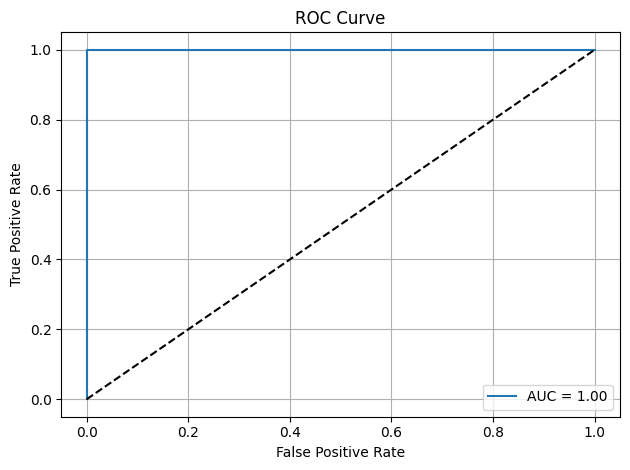

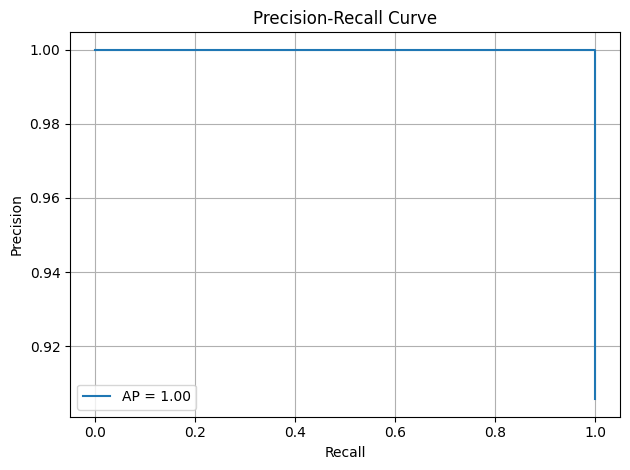

In [48]:
y_pred_attack = stacked.predict(X_test)
y_proba = stacked.predict_proba(X_test)[:, 1]
display_metrics(y_test["attack"], y_pred_attack,"Attack",y_proba)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:47:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:48:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:48:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:48:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'mult


--- category ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.999833  0.999333  0.999583   6000.0
1   0.999334  1.000000  0.999667   6000.0
2   1.000000  0.608377  0.756510   1910.0
3   0.889152  0.999833  0.941250   6001.0
4   1.000000  1.000000  1.000000    331.0

📊 Confusion Matrix:


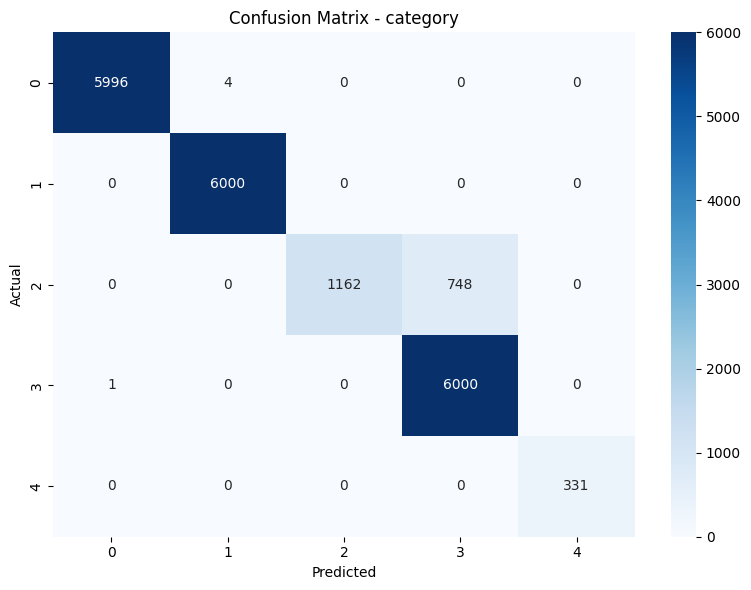


✅ Accuracy: 0.9628
✅ Weighted F1 Score: 0.9594
✅ Macro F1 Score: 0.9394
✅ Macro Precision: 0.9777
✅ Macro Recall: 0.9215
❌ Hamming Loss: 0.037200


In [75]:

stacked = StackingClassifier(
    estimators=[('xgb', xgb), ('rf', rf)],
    final_estimator=meta_model,
    cv=cv,
    passthrough=False,
    n_jobs=1
)
X_cat = np.concatenate([X_train, y_train["attack"].values.reshape(-1, 1)], axis=1)

stacked.fit(X_cat, y_train["category"])


X_cat_test = np.concatenate([X_test, y_pred_attack.reshape(-1, 1)], axis=1)
y_pred_category = stacked.predict(X_cat_test)

display_metrics(y_test["category"], y_pred_category, title="category")


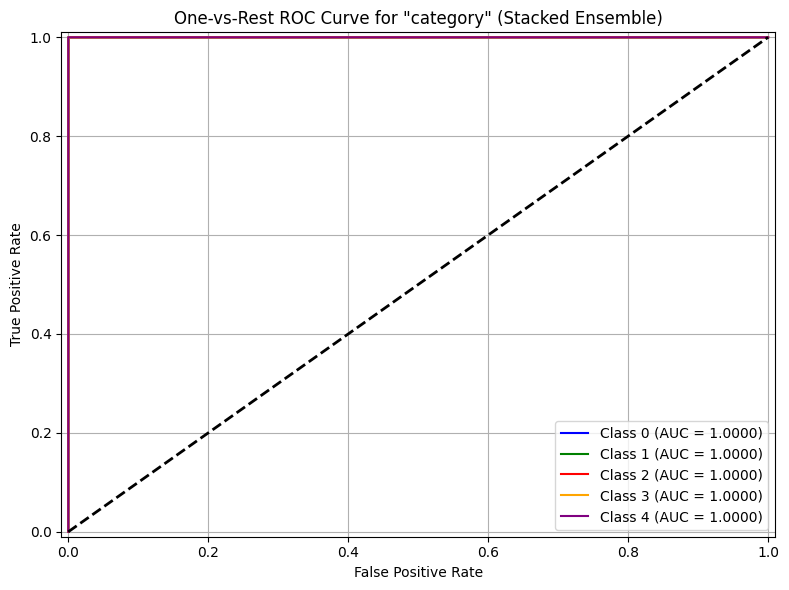

In [77]:
y_proba = stacked.predict_proba(X_cat_test)
y_true = y_test["category"].values
classes = [0,1,2,3,4]
y_bin = label_binarize(y_true, classes=classes)
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and AUC for each class
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red', 'orange', 'purple']

for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f'Class {i} (AUC = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-Rest ROC Curve for "category" (Stacked Ensemble)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

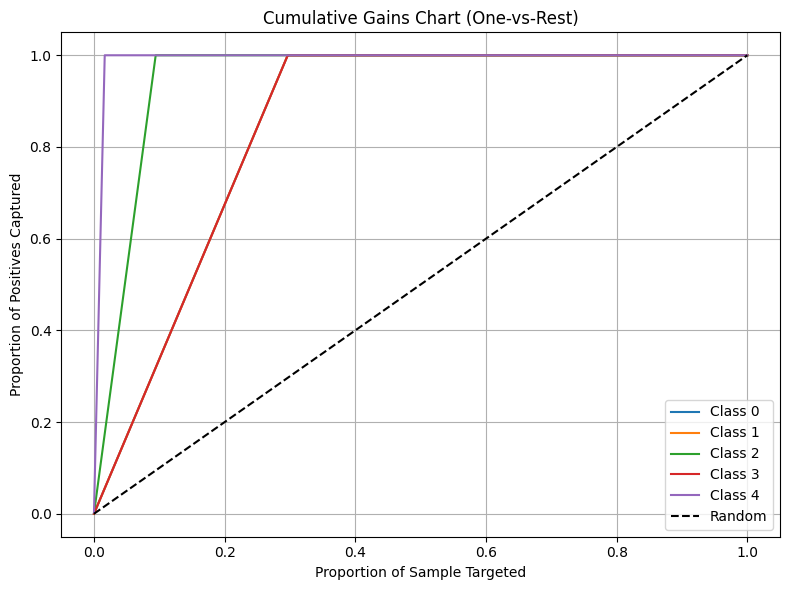

In [70]:


# 2) Get your predicted probs for category
y_score = stacked.predict_proba(X_cat_test)  # shape (n_samples,5)

# 3) Compute cumulative gains
plt.figure(figsize=(8,6))
for i in range(5):
    # sort by descending probability for class i
    idx = np.argsort(y_score[:,i])[::-1]
    cum_positives = np.cumsum(y_bin[idx, i])
    cum_pct_positives = cum_positives / cum_positives[-1]
    cum_pct_samples   = np.arange(1, len(idx)+1) / len(idx)
    plt.plot(cum_pct_samples, cum_pct_positives,
             label=f'Class {classes[i]}')

# perfect model for reference
plt.plot([0,1], [0,1], 'k--', label='Random')

plt.xlabel("Proportion of Sample Targeted")
plt.ylabel("Proportion of Positives Captured")
plt.title("Cumulative Gains Chart (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

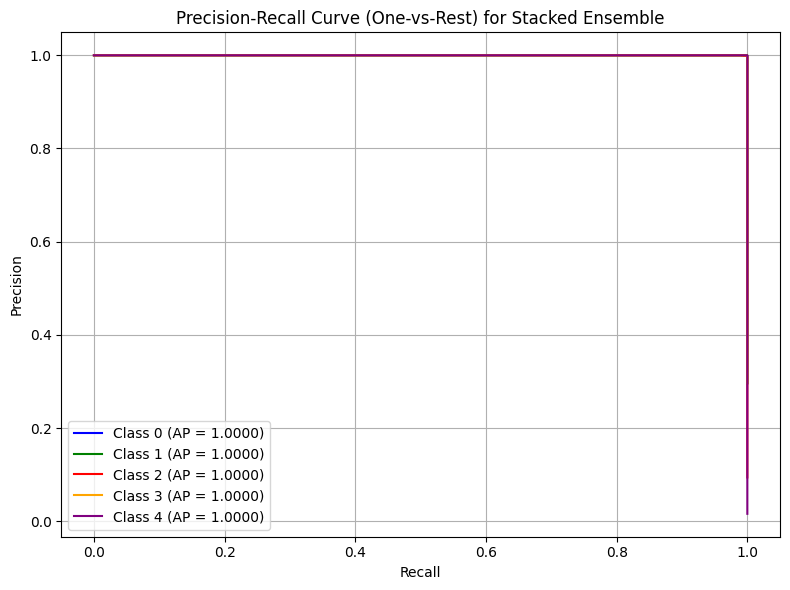

In [71]:
y_test_bin = label_binarize(y_test["category"], classes=[0, 1, 2, 3, 4])

# Compute PR curve and AP for each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(5):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_proba[:, i])

# Plotting PR curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red', 'orange', 'purple']

for i, color in zip(range(5), colors):
    plt.plot(recall[i], precision[i], color=color,
             label=f'Class {i} (AP = {average_precision[i]:.4f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (One-vs-Rest) for Stacked Ensemble')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

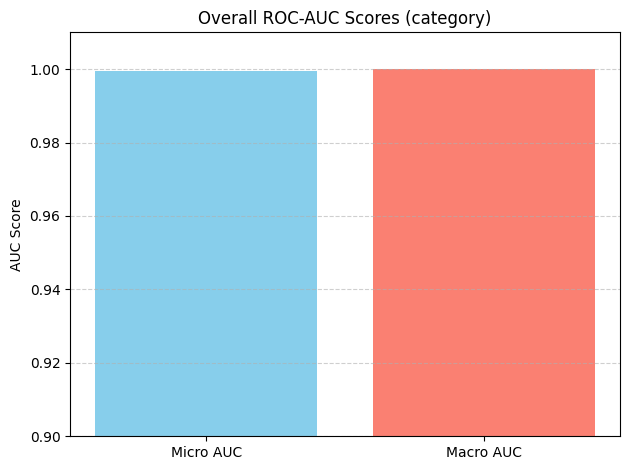

In [73]:

y_bin = label_binarize(y_test["category"], classes=[0, 1, 2, 3, 4])
micro_auc = roc_auc_score(y_bin, y_proba, average='micro')
macro_auc = roc_auc_score(y_bin, y_proba, average='macro')

plt.bar(['Micro AUC', 'Macro AUC'], [micro_auc, macro_auc], color=['skyblue', 'salmon'])
plt.ylim([0.9, 1.01])
plt.title('Overall ROC-AUC Scores (category)')
plt.ylabel('AUC Score')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

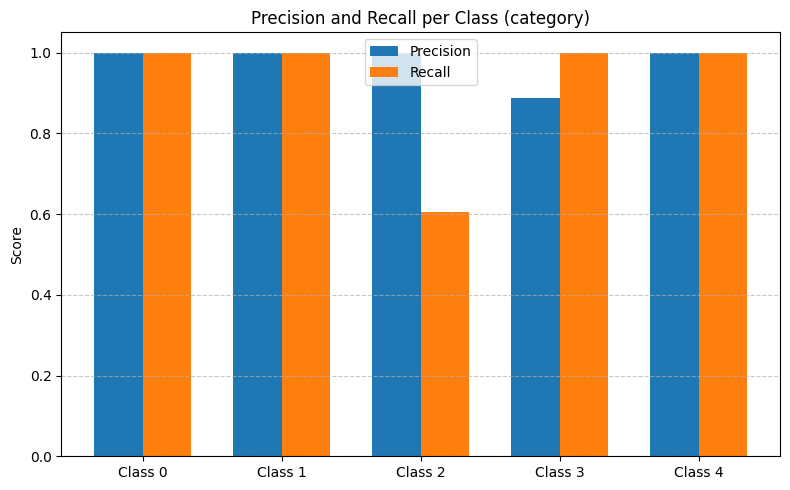

In [74]:
precision = precision_score(y_test["category"], y_pred_category, average=None)
recall = recall_score(y_test["category"], y_pred_category, average=None)

x = np.arange(5)
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, precision, width, label='Precision')
ax.bar(x + width/2, recall, width, label='Recall')

ax.set_xticks(x)
ax.set_xticklabels([f'Class {i}' for i in range(5)])
ax.set_ylim([0, 1.05])
ax.set_ylabel('Score')
ax.set_title('Precision and Recall per Class (category)')
ax.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [63]:
print("y_test shape:", y_test.shape)
print("y_proba shape:", y_proba.shape)
print("Unique labels in y_test:", np.unique(y_test))

y_test shape: (20242, 3)
y_proba shape: (20242, 5)
Unique labels in y_test: [0 1 2 3 4 5 6 7]


In [58]:
np.array(y_proba).shape


(20242, 5)

In [61]:
np.array(y_test["category"]).shape

(20242,)

In [78]:
stacked = StackingClassifier(
    estimators=[('xgb', xgb), ('rf', rf)],
    final_estimator=meta_model,
    cv=cv,
    passthrough=False,
    n_jobs=1
)

X_subcat = np.concatenate([X_cat, y_train["category"].values.reshape(-1, 1)], axis=1)

stacked.fit(X_subcat, y_train["subcategory"])
X_subcat_test = np.concatenate([X_cat_test, y_pred_category.reshape(-1, 1)], axis=1)

y_pred = stacked.predict(X_subcat_test)




/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:52:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:52:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:53:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:53:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'mult


--- Subcategory ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.656250  0.875000  0.750000     24.0
1   0.444444  0.888889  0.592593      9.0
2   0.989967  0.964169  0.976898    307.0
3   1.000000  1.000000  1.000000   1910.0
4   0.971572  0.994863  0.983080   1168.0
5   0.998959  0.992965  0.995953   4833.0
6   0.999810  0.998291  0.999050   5265.0
7   1.000000  1.000000  1.000000   6726.0

📊 Confusion Matrix:


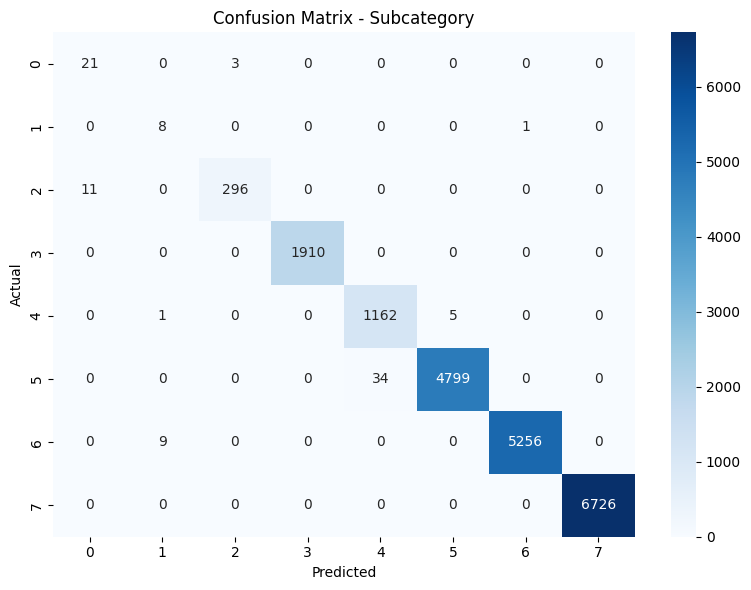


✅ Accuracy: 0.9968
✅ Weighted F1 Score: 0.9970
✅ Macro F1 Score: 0.9122
✅ Macro Precision: 0.8826
✅ Macro Recall: 0.9643
❌ Hamming Loss: 0.003162


In [79]:


display_metrics(y_test["subcategory"], y_pred, title="Subcategory")

